In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec as hp
from pyuvdata import UVData
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import lognorm, chi2, norm
from scipy.optimize import curve_fit

In [2]:
# Load beam model
beamfile = 'HERA_NF_dipole_power.beamfits'
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Load data into UVData objects
dfile = 'zen.2458116.34176.xx.HH.uvOCRS'
uvd = UVData()
uvd.read_miriad(dfile)

In [3]:
# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0) # Phase to the zeroth dataset

In [76]:
# Specify which baselines to include
baselines = [(66, 67), (83, 84), (37, 38)]
# baselines = [(66, 67), (83, 84), (69, 70)]
# baselines = [(37, 38), (83, 84), (69, 70)]

# Define uvp
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (500, 600)],  input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True) 


Setting spectral range: (300, 400)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (500, 600)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)
 

Text(0.5, 1.0, 'spw : 1, blpair : ((66, 67), (66, 67)), pol : xx')

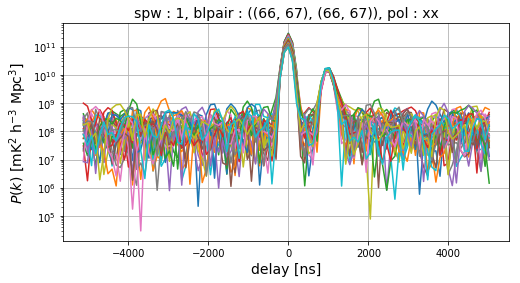

In [77]:
# with cable reflection #1
spw = 1
blp = ((66, 67), (66, 67))
# blp = ((37, 38), (37, 38))
key1 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power1 = np.abs(np.real(uvp.get_data(key1)))

# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(8,4))
p1 = ax.plot(dlys, power1.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key1), fontsize=14)

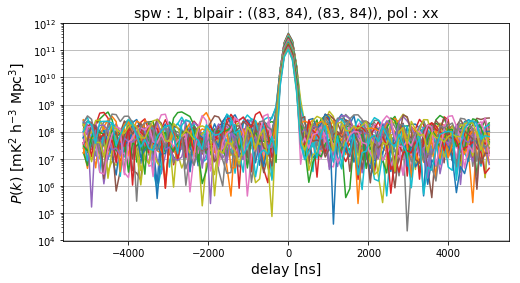

In [78]:
# no cable reflection #1
spw = 1
blp = ((83, 84), (83, 84))
# blp = ((82, 120), (82, 120))
key2 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power2 = np.abs(np.real(uvp.get_data(key2)))

# plot power spectrum of spectral window 1
plt.figure(figsize=(8,4))
plt.semilogy(dlys, power2.T)
plt.grid()
plt.xlabel("delay [ns]", fontsize=14)
plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
plt.title("spw : {}, blpair : {}, pol : {}".format(*key2), fontsize=14)
plt.show()

Text(0.5, 1.0, 'spw : 1, blpair : ((37, 38), (37, 38)), pol : xx')

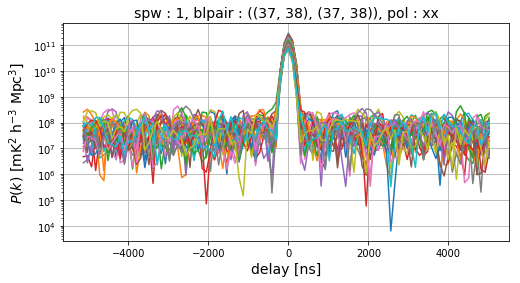

In [80]:
# no cable reflection #2
spw = 1
blp = ((37, 38), (37, 38))
# blp = ((69, 70), (69, 70))
key3 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power3 = np.abs(np.real(uvp.get_data(key3)))

# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(8,4))
p1 = ax.plot(dlys, power3.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key3), fontsize=14)

In [213]:
# Labels for future plots
def label_z_test():
    plt.hlines(total, x[0], x[-1])
    plt.text(3800, 27,'total', fontsize=12)
    plt.title('Number of groups rejecting H0', fontsize=14)
    plt.xlabel('delay [ns]', fontsize=12)
    plt.ylabel('counts', fontsize=12)
    
def label_null_test_hist():
    plt.title('Null test', fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.xlabel('difference', fontsize=12)
    
def label_null_test(x, avg):
    if avg == 'time':
        plt.hlines(0, x[0], x[-1])
        plt.xlabel('time', fontsize=12)
    plt.title('Null test', fontsize=12)
    plt.ylabel('difference', fontsize=12)
    if avg == 'delay':
        plt.xlabel('delay [ns]', fontsize=12)
    if avg == 'no':
#         plt.tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom=False,      # ticks along the bottom edge are off
#             top=False,         # ticks along the top edge are off
#             labelbottom=False)
        plt.hlines(0, x[0], x[-1])
        plt.xlabel('data samples', fontsize=12)

In [140]:
# Perform two-sample z-test

# Number of groups which rejects H0 (don't have the same mean)
count = {}

power = {0: power1, 1:power2, 2:power3}
key = {0: key1, 1:key2, 3:key3}

# Set delay domain
dly = [-5000, 5000]
# Number of groups going through the test
dly_rg = 200
# Red vertical lines that divides power data into dly_rg groups
lines = []
# Total number of power in one group for one baseline pair
total = 0

for k in range(2):
    h0 = []
    x = []
    power_a = power[k] # k=0>>>power1, k=1>>>power2
    power_b = power[k+1] # k=0>>>power2, k=1>>>power3
    
    for i in range(int((dly[-1]-dly[0])/dly_rg)):
        dly_modes = [dly[0]+dly_rg*i, dly[0]+dly_rg*(i+1)]
        lines.append(dly_modes)
        
        dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]
        x.append(int((dly[0]+dly_rg*i+dly[0]+dly_rg*(i+1))/2))
        
        # get data in delay mode domain
        data_a = power_a[:][:,dly_idx[0]:dly_idx[1]]
        data_b = power_b[:][:,dly_idx[0]:dly_idx[1]]

        pval = {}
        for i in range(len(data_a)):
            if k == 0: # data2, data1
                pval[i] = stests.ztest(data_b[i], data_a[i], value=0, alternative='two-sided')[1]
            if k == 1: # data2, data3
                pval[i] = stests.ztest(data_a[i], data_b[i], value=0, alternative='two-sided')[1]

        z_stats = list(pval.values())

        a = 0
        for j in range(len(z_stats)):
            if z_stats[j] < 0.05:
                a += 1
        h0.append(a)
    total = len(data_a)
    count[k] = h0

invalid value encountered in double_scalars


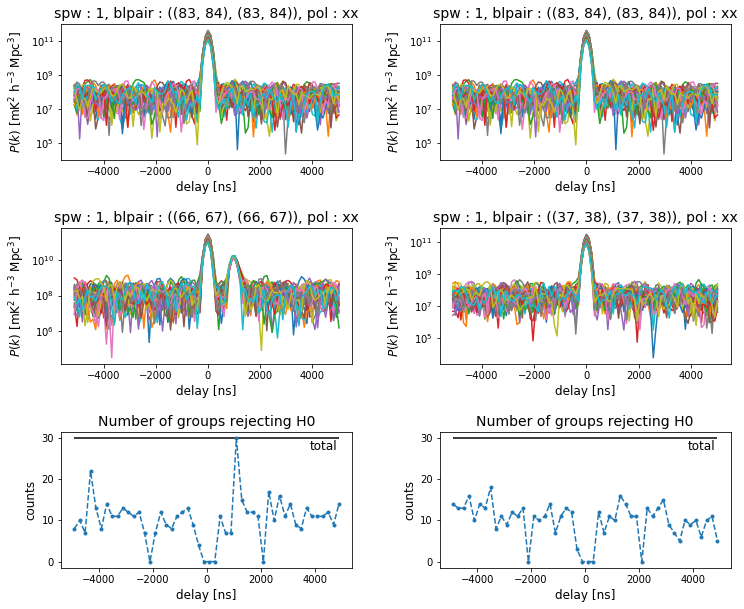

In [141]:
# Plot z-test results
plt.subplots(3, 2, sharex=True, figsize=(12, 10))
plt.subplots_adjust(hspace=.5, wspace=.3)
for i in range(6):
    pos = 321+i
    plt.subplot(pos)
    if i == 0:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 1:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 2:
        idx = 0
        plt.semilogy(dlys, power[0].T)
    elif i == 3:
        idx = 3
        plt.semilogy(dlys, power[2].T)
    elif i == 4:
        plt.plot(x, count[0], '.--')
        label_z_test()
        continue
    else:
        plt.plot(x, count[1], '.--')
        label_z_test()
        continue
    plt.xlabel("delay [ns]", fontsize=12)
    plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=12)
    plt.title("spw : {}, blpair : {}, pol : {}".format(*key[idx]), fontsize=14)

In [202]:
def null_test(dly1, dly2, avg):
    # null test
    dly_modes = [dly1, dly2] # ns
    dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]

    diff = {}
    for i in range(2):
        power_a = power[i] # i=0>>>power1, i=1>>>power2
        power_b = power[i+1] # i=0>>>power2, i=1>>>power3
        
        if avg == 'no':
           # get data in delay mode domain
            data_a = power_a[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data1, i=1>>>data2
            data_b = power_b[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data2, i=1>>>data3
        
            # subtraction
            if i == 0: # data2 - data1
                diff[i] = data_b.flatten() - data_a.flatten()
            if i == 1: # data2 - data3
                diff[i] = data_a.flatten() - data_b.flatten()
            
        if avg == 'delay':        
            # get data in delay mode domain
            data_a = np.mean(power_a[:][:,dly_idx[0]:dly_idx[1]], axis=0) # i=0>>>data1, i=1>>>data2
            data_b = np.mean(power_b[:][:,dly_idx[0]:dly_idx[1]], axis=0) # i=0>>>data2, i=1>>>data3
            # subtraction
            if i == 0:
                diff[i] = data_b-data_a
            if i == 1:
                diff[i] = data_a-data_b
                
        if avg == 'time':      
            # get data in delay mode domain
            data_a = np.mean(power_a[:][:,dly_idx[0]:dly_idx[1]], axis=1) # i=0>>>data1, i=1>>>data2
            data_b = np.mean(power_b[:][:,dly_idx[0]:dly_idx[1]], axis=1) # i=0>>>data2, i=1>>>data3
            # subtraction
            if i == 0:
                diff[i] = data_b-data_a
            if i == 1:
                diff[i] = data_a-data_b
        
        # create x-axis when avg='delay'
        inc = (dly2-dly1)/len(diff[0])
        ddly = []
        for i in range(len(diff[0])):
            ddly.append(dly1+inc*(i+1)-(inc/2))             
            
    # Fit the null-test results (differences) with Gaussain distribution
    mu = []
    std = []
    for i in range(len(diff)):
        mu.append(norm.fit(diff[i])[0])
        std.append(norm.fit(diff[i])[1])

    # Perform AD-test to see if the null test results are randomly distributed
    # get cdf of each dataset
    cdf = []
    for i in range(len(diff)):
        cdf.append(np.array(range(len(diff[i])))/float(len(diff[i])))

    # get cdf of each fit
    norm_cdf = []
    for i in range(len(diff)):
        norm_cdf.append(norm.cdf(np.sort(diff[i]), mu[i], std[i]))

    a = []
    for i in range(len(diff)):
        a.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[0])
    cv = stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1]

    # Plot null-test results
    norm_x = [np.linspace(min(diff[0]), max(diff[0]), 1000), np.linspace(min(diff[1]), max(diff[1]), 1000)]
    x = np.linspace(0, len(diff[0])-1, len(diff[0]))
    plt.subplots(4, 2, sharex=True, figsize=(12, 10))
    plt.subplots_adjust(hspace=.6, wspace=.3)
    for i in range(8):
        pos = 421+i
        plt.subplot(pos)
        if i == 0:
            idx = 1
            plt.semilogy(dlys, power[1].T)
        elif i == 2:
            idx = 0
            plt.semilogy(dlys, power[0].T)
        elif i == 1:
            idx = 1
            plt.semilogy(dlys, power[1].T)
        elif i == 3:
            idx = 3
            plt.semilogy(dlys, power[2].T)
        elif i == 4:
            label_null_test(x, avg)
            if avg == 'no' or avg == 'time':
                plt.plot(x, diff[0], '.')
            if avg == 'delay':
                plt.plot(ddly, diff[0], '.')
                plt.hlines(0, ddly[0], ddly[-1])
            continue
        elif i == 5:
            label_null_test(x, avg)
            if avg == 'no' or avg == 'time':
                plt.plot(x, diff[1], '.')
            if avg == 'delay':
                plt.plot(ddly, diff[1], '.')
                plt.hlines(0, ddly[0], ddly[-1])
            continue
        elif i == 6:
            plt.hist(diff[0], bins='auto', density=True, histtype='bar', rwidth=0.8)
            plt.plot(norm_x[0], norm.pdf(norm_x[0], loc=mu[0], scale=std[0]))
            label_null_test_hist()
            continue
        else:
            plt.hist(diff[1], bins='auto', density=True, histtype='bar', rwidth=0.8)
            plt.plot(norm_x[1], norm.pdf(norm_x[1], loc=mu[1], scale=std[1]))
            label_null_test_hist()
            continue
        # Box regions that went through the tests
        plt.vlines(dly_modes[0], 1e4, 1e10)
        plt.vlines(dly_modes[1], 1e4, 1e10)
        plt.hlines(1e4, dly_modes[0], dly_modes[1])
        plt.hlines(1e10, dly_modes[0], dly_modes[1])
        plt.xlabel("delay [ns]", fontsize=12)
        plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=12)
        plt.title("spw : {}, blpair : {}, pol : {}".format(*key[idx]), fontsize=12)
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(2, a[0], 'k*', label='cable reflection')
    plt.plot(2, a[1], 'k^', label='no cable reflection')
    plt.plot(11, 3, alpha=0)
    plt.hlines(cv[2], 0, 4, 'r', label='critical value for the 5% level')
    plt.hlines(cv[3], 0, 4, 'b', label='critical value for the 2.5% level')
    plt.hlines(cv[4], 0, 4, 'k', label='critical value for the 1% level')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.legend(loc='center right')
    plt.ylabel('test value')
    plt.title('AD-test')

19


p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25


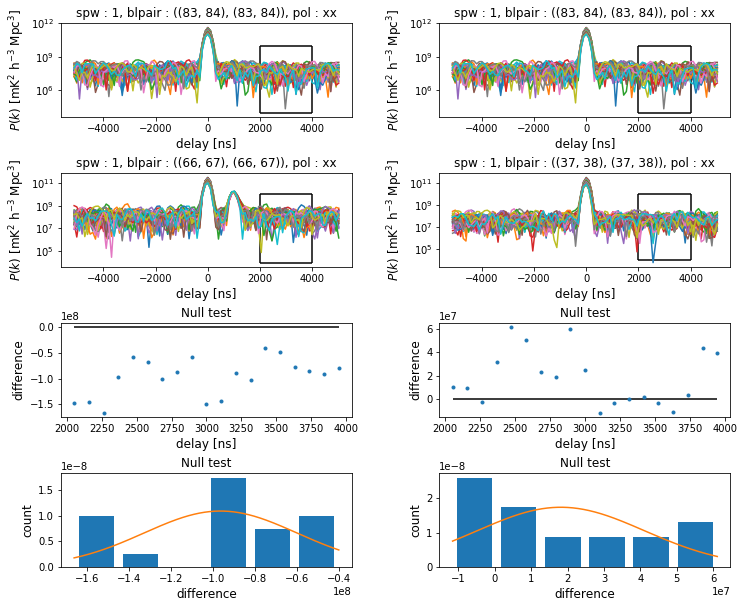

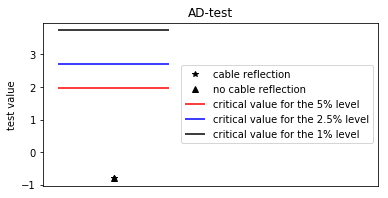

In [211]:
null_test(2000, 4000, 'delay')

(30, 10)
(30, 10)
300


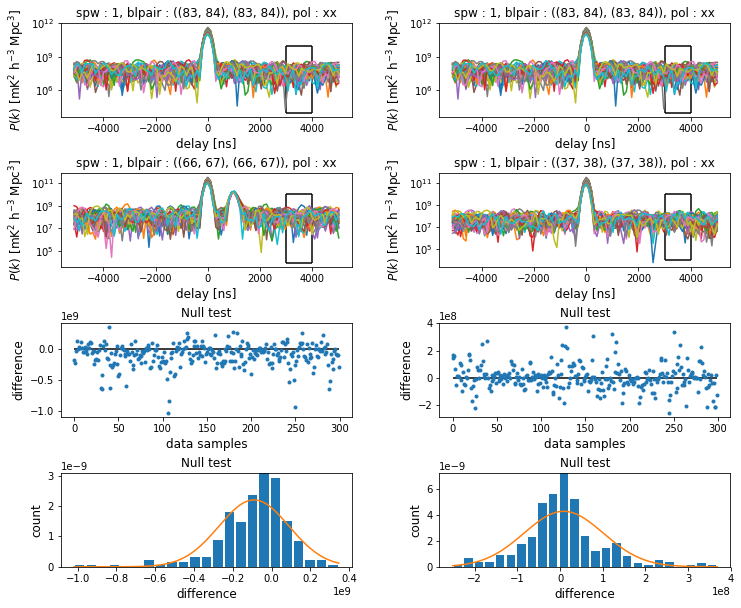

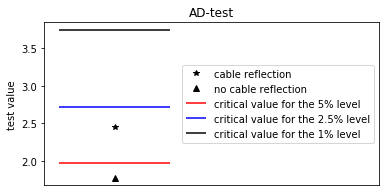

In [214]:
null_test(3000, 4000,'no')

In [87]:
def null_test_fit(dly1, dly2):
    # null test
    dly_modes = [dly1, dly2] # ns
    dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]

    diff = {}
    for i in range(2):
        power_a = power[i] # i=0>>>power1, i=1>>>power2
        power_b = power[i+1] # i=0>>>power2, i=1>>>power3

        # get data in delay mode domain
        data_a = power_a[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data1, i=1>>>data2
        data_b = power_b[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data2, i=1>>>data3

        # subtraction
        if i == 0: # data2 - data1
            diff[i] = data_b.flatten() - data_a.flatten()
        if i == 1: # data2 - data3
            diff[i] = data_a.flatten() - data_b.flatten()
            
    # Fit the null-test results (differences) with Gaussain distribution
    mu = []
    err = []
    for i in range(len(diff)):
        mu.append(norm.fit(diff[i])[0])
        err.append((norm.fit(diff[i])[1])/len(diff[i]))
        
    return (np.asarray(mu), np.asarray(err))

In [88]:
delay = [1500, 5000]
step = 500
gaus_fit = []
gaus_x = []
xticks = []
length = int((delay[-1]-delay[0])/step)
for i in range(length):
    gaus_fit.append(null_test_fit(delay[0]+step*i, delay[0]+step*(i+1)))
    gaus_x.append(i)
    xticks.append('['+str(delay[0]+step*i)+', '+str(delay[0]+step*(i+1))+']')
gaus_fit = np.asarray(gaus_fit) 

[-105169932.94706477, 22894276.879801787]
[-138983414.89816007, 12056271.855589323]
[-74069112.66263875, 42560735.78528883]
[-104742653.25293365, 2424843.116707924]
[-76541280.71682912, 14278530.883836292]
[-105454548.77252388, 21771633.75131381]
[-89889089.86626647, 39049727.13319921]


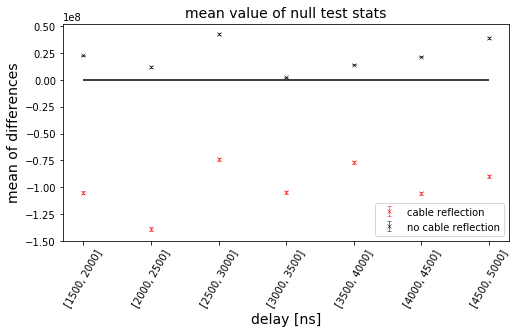

In [89]:
plt.figure(figsize=(8, 4))
plt.errorbar(gaus_x, gaus_fit[:,0,:].T[0], yerr=gaus_fit[:,1,:].T[0],
             color = 'red', fmt = 'x', markersize = '4',
             ecolor = 'red', capsize = 2, elinewidth = 0.5, 
             markeredgewidth = 0.5, label='cable reflection') 
plt.errorbar(gaus_x, gaus_fit[:,0,:].T[1], yerr=gaus_fit[:,1,:].T[1], 
             color = 'black', fmt = 'x', markersize = '4', 
             ecolor = 'black', capsize = 2, elinewidth = 0.5, 
             markeredgewidth = 0.5, label='no cable reflection') 
plt.hlines(0, gaus_x[0], gaus_x[-1])
plt.xticks(gaus_x, xticks, rotation=60)
plt.ylabel('mean of differences', fontsize=14)
plt.xlabel('delay [ns]', fontsize=14)
plt.title('mean value of null test stats', fontsize=14)
plt.legend()
plt.show()

In [75]:
def null_test_ad(dly1, dly2):
    # null test
    dly_modes = [dly1, dly2] # ns
    dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]

    diff = {}
    for i in range(2):
        power_a = power[i] # i=0>>>power1, i=1>>>power2
        power_b = power[i+1] # i=0>>>power2, i=1>>>power3

        # get data in delay mode domain
        data_a = power_a[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data1, i=1>>>data2
        data_b = power_b[:][:,dly_idx[0]:dly_idx[1]] # i=0>>>data2, i=1>>>data3

        # subtraction
        if i == 0: # data2 - data1
            diff[i] = data_b.flatten() - data_a.flatten()
        if i == 1: # data2 - data3
            diff[i] = data_a.flatten() - data_b.flatten()

    # Fit the null-test results (differences) with Gaussain distribution
    mu = []
    std = []
    for i in range(len(diff)):
        mu.append(norm.fit(diff[i])[0])
        std.append(norm.fit(diff[i])[1])

    # Perform AD-test to see if the null test results are randomly distributed
    # get cdf of each dataset
    cdf = []
    for i in range(len(diff)):
        cdf.append(np.array(range(len(diff[i])))/float(len(diff[i])))

    # get cdf of each fit
    norm_cdf = []
    for i in range(len(diff)):
        norm_cdf.append(norm.cdf(np.sort(diff[i]), mu[i], std[i]))

    a = []
    for i in range(len(diff)):
        a.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[0])
    cv = stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1]

    return (np.asarray(a), cv)

In [20]:
delay = [1500, 5000]
step = 500
length = int((delay[-1]-delay[0])/step)
ad_stats = []
cv = []
ad_x = []
ad_xticks = []
for i in range(length):
    ad_stats.append(null_test_ad(delay[0]+step*i, delay[0]+step*(i+1))[0])
    cv.append(null_test_ad(delay[0]+step*i, delay[0]+step*(i+1))[1])
    ad_x.append(i)
    ad_xticks.append('['+str(delay[0]+step*i)+', '+str(delay[0]+step*(i+1))+']')
ad_stats = np.asarray(ad_stats)
cv = np.asarray(cv)

p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value larger than 0.25
p-value capped: true value large

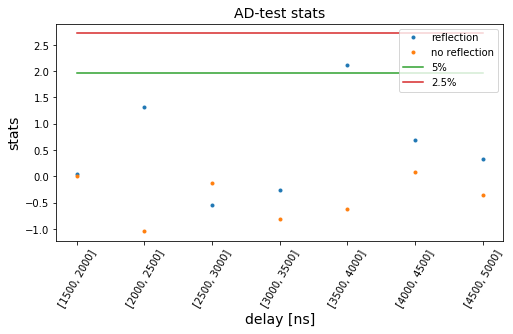

In [21]:
plt.figure(figsize=(8,4))
plt.plot(ad_x, ad_stats.T[0], '.', label=('reflection'))
plt.plot(ad_x, ad_stats.T[1], '.', label=('no reflection'))
plt.plot(ad_x, cv[:,2], '-', label=('5%'))
plt.plot(ad_x, cv[:,3], '-', label=('2.5%'))
plt.legend(loc='upper right')
plt.xticks(ad_x, ad_xticks, rotation=60)
plt.ylabel('stats', fontsize=14)
plt.xlabel('delay [ns]', fontsize=14)
plt.title('AD-test stats', fontsize=14)
plt.show()

In [119]:
dly_modes = [2000, 3000] # ns
dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]

diff = {}
for i in range(2):
    power_a = power[i] # i=0>>>power1, i=1>>>power2
    power_b = power[i+1] # i=0>>>power2, i=1>>>power3

    # get data in delay mode domain
    data_a = np.mean(power_a[:][:,dly_idx[0]:dly_idx[1]], axis=1) # i=0>>>data1, i=1>>>data2
    data_b = np.mean(power_b[:][:,dly_idx[0]:dly_idx[1]], axis=1) # i=0>>>data2, i=1>>>data3
    # subtraction
    if i == 0: # data2 - data1
#         diff[i] = data_b.flatten() - data_a.flatten()
        diff[i] = data_b-data_a
    if i == 1: # data2 - data3
#         diff[i] = data_a.flatten() - data_b.flatten()
        diff[i] = data_a-data_b